In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


from pprint import pprint

from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
data = pd.read_csv("Data (version 3) without dummy variables.csv")

# Split into features and target variables
X = data.drop(['tensile_strength', 'thermal_conductivity'], axis=1)
y = data['tensile_strength']

from sklearn.preprocessing import LabelEncoder

X_transformed = X.copy()
encoder = LabelEncoder()
transformed_temper_code = encoder.fit_transform(X['Temper Code'])
transformed_form = encoder.fit_transform(X['Form'])

X_transformed['Form'] = transformed_form
X_transformed['Temper Code'] = transformed_temper_code

# Split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

# Hyperparameter Tuning for each model

**1. Random Forest Regressor** 

a. Hyperparamter tuning with **RandomizedSearchCV**\
b. Hyperparamter tuning with **GridSearchCV**

#### Random Search Cross Validation

In [3]:
# Create grid for RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]


# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [136]:
# Use the random grid to search for best hyperparameters

# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf,
                               param_distributions = random_grid,
                               n_iter = 100,
                               cv = 3,   # 3 folds
                               verbose=2,
                               random_state=42,
                               n_jobs = -1)
# Fit the random search model
_ = rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   25.4s finished


In [139]:
mean_cv_scores = rf_random.cv_results_['mean_test_score']
std_cv_scores = rf_random.cv_results_['std_test_score']

cv_means_random = mean_cv_scores[mean_cv_scores.argsort()]
cv_std_random = std_cv_scores[mean_cv_scores.argsort()]

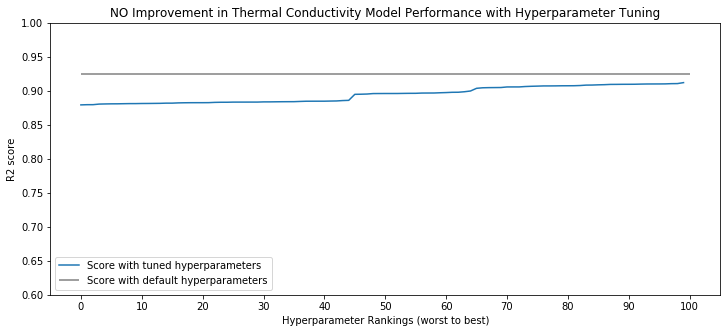

In [141]:
plt.figure(figsize=(12,5))
# sns.lineplot(x=np.arange(len(cv_means)), y = cv_means)
sns.lineplot(x=np.arange(len(cv_means_random)), y = cv_means_random)
plt.ylim([0.6,1])
plt.hlines(y=0.924536, xmin=0, xmax=len(cv_means_random), alpha=0.5)
plt.legend(['Score with tuned hyperparameters', 'Score with default hyperparameters'], loc='lower left')
plt.xlabel("Hyperparameter Rankings (worst to best)")
plt.ylabel("R2 score")
plt.title("NO Improvement in Thermal Conductivity Model Performance with Hyperparameter Tuning")
plt.xticks(np.arange(0, len(cv_means_random)+1, 10))
plt.show()

(0.6, 1)

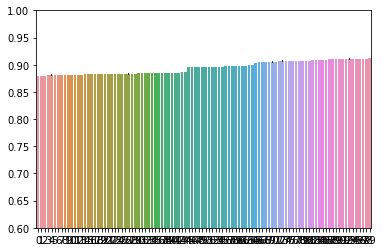

In [143]:
sns.barplot(x=np.arange(len(cv_means_random)), y = cv_means_random, xerr=cv_std)
plt.ylim([0.6,1])

We can view the **best parameters** from fitting the random search:

In [144]:
rf_random.best_params_

{'n_estimators': 122,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 60,
 'bootstrap': True}

### Evaluate Random Search

To determine if random search yielded a better model, we **compare the base model** with the **best random search model**.

#### Grid Search Cross Validation

To use Grid Search, we **make another grid based on the best values provided by random search**

In [145]:
# Create the parameter grid based on the results of random search 


param_grid = {
    'bootstrap': [True],
    'max_depth': [60, 80, 100, None],
    'max_features': ['auto'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 3],
    'n_estimators': [122, 130, 140]
}

# Create a based model
rf = RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:   18.7s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [146]:
mean_cv_scores = grid_search.cv_results_['mean_test_score']
std_cv_scores = grid_search.cv_results_['std_test_score']

std_cv_scores = std_cv_scores[~np.isnan(mean_cv_scores)]
mean_cv_scores = mean_cv_scores[~np.isnan(mean_cv_scores)]

cv_means = mean_cv_scores[mean_cv_scores.argsort()]
cv_std = std_cv_scores[mean_cv_scores.argsort()]

# cv_means = np.concatenate(([0.924536], cv_means))
# cv_std = np.concatenate(([0.038171], cv_std))

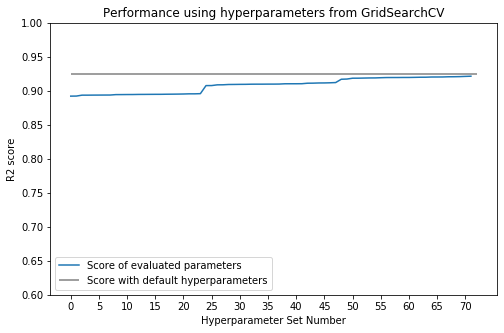

In [147]:
plt.figure(figsize=(8,5))
sns.lineplot(x=np.arange(len(cv_means)), y = cv_means)
plt.ylim([0.6,1])
plt.hlines(y=0.924536, xmin=0, xmax=len(cv_means), alpha=0.5)
plt.legend(['Score of evaluated parameters', 'Score with default hyperparameters'], loc='lower left')
plt.xlabel("Hyperparameter Set Number")
plt.ylabel("R2 score")
plt.title("Performance using hyperparameters from GridSearchCV")
plt.xticks(np.arange(0, len(cv_means), 5))
plt.show()

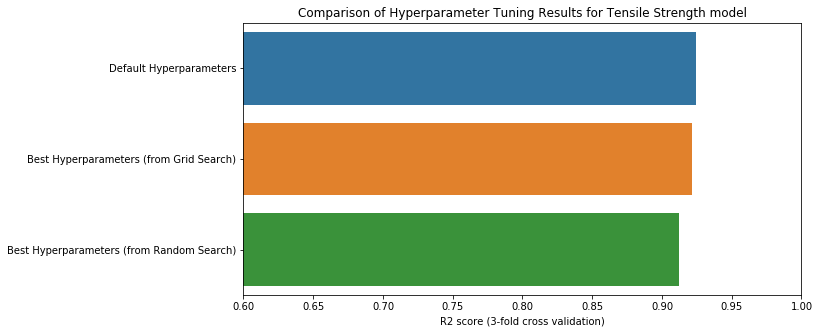

In [149]:
scores = [0.924536, cv_means.max(), cv_means_random.max()]
labels = ['Default Hyperparameters', 'Best Hyperparameters (from Grid Search)', 'Best Hyperparameters (from Random Search)']

plt.figure(figsize=(10,5))
sns.barplot(y=labels, x=scores)
plt.xlim([0.6,1])
plt.title("Comparison of Hyperparameter Tuning Results for Tensile Strength model")
plt.xlabel("R2 score (3-fold cross validation)")

plt.show()

##### Best hyperparameters = Default

In [4]:
model = RandomForestRegressor()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

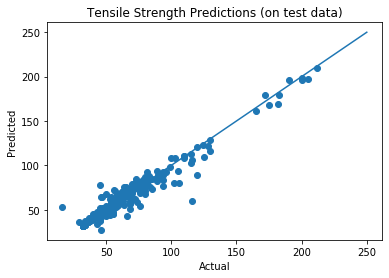

In [5]:
plt.scatter(y_test, y_pred)
plt.plot([50, 250], [50,250])
plt.title("Tensile Strength Predictions (on test data)")
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.show()

In [6]:
plt.scatter(y_test, grid_search.best_estimator_.predict(X_test))
plt.plot([50, 250], [50,250])
plt.title("Tensile Strength Predictions")
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.show()

NameError: name 'grid_search' is not defined

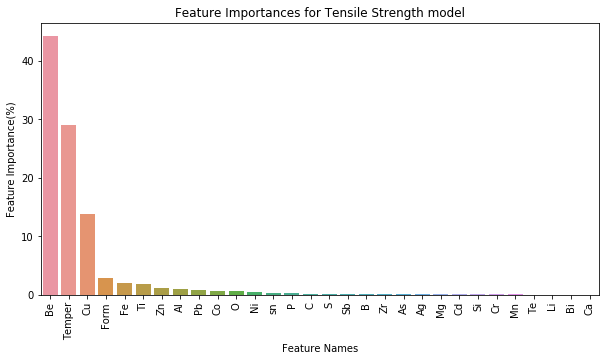

In [10]:
model = RandomForestRegressor()
model.fit(X_train, y_train)

feature_importance = model.feature_importances_
features = X_train.columns

f_imp = feature_importance[feature_importance.argsort()[::-1]] * 100
fts = features[feature_importance.argsort()[::-1]]
fts = fts.str.replace('Temper Code', 'Temper')

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=fts, y=f_imp, ax=ax)
ax.set_title("Feature Importances for Tensile Strength model")
ax.set_xlabel("Feature Names")
ax.set_ylabel("Feature Importance(%)")

plt.xticks(rotation='vertical')

plt.show()